In [219]:
# %pip install python-dotenv
# %pip install seaborn
# %pip install tensorflow_data_validation
#  %pip install git+https://github.com/tensorflow/docs



In [220]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
# import tensorflow as tf
# import tensorflow_data_validation as tfdv
import sklearn as sk
import scipy as sp
import seaborn as sns
# from datetime import datetime
# from dotenv import load_dotenv
from IPython.display import clear_output
from matplotlib import pyplot as plt
from shapely import wkt


In [221]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('F:\\Uni Files\\4710\\4710 Project\\MLweatherForestFire')


In [222]:
def getGPDfromPD(df: pd.DataFrame, geomCol: str, crs: str = "EPSG:3978") -> gpd.GeoDataFrame:
    """
    Convert a pandas dataframe to a geopandas dataframe
    :param df: pandas dataframe
    :param geomCol: name of the geometry column
    :param crs: coordinate reference system
    :return: geopandas dataframe
    """
    if 'geom' in df.columns:
        df.rename(columns={'geom': 'geometry'}, inplace=True)

    df[geomCol] = df[geomCol].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry=geomCol, crs=crs)
    return gdf


In [223]:
fireWeatherTable = "Data/FinalFeatureV2.csv"
dfFireWeather = pd.read_csv(fireWeatherTable)


In [224]:
dfEval = dfFireWeather.copy(deep=True)
dfEval.describe()

,ENTRYID,YEAR,MONTH,DAY,SIZE_HA,SIZE_HA_BIN,ELEVATIONM,DIST_TO_WATER,DAYW,MAXTEMP,MEANHUMIDITY,MEANWINDSPEED,MAXWINDSPEED,TOTALPRECIP,LONG,LAT,LONGBIN,LATBIN,utc,7daySumMaxTemp,7daySumHumidity,7daySumWindSpeed,14daySumMaxTemp,14daySumHumidity,14daySumWindSpeed
count,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0,836.0
mean,1143.2,2009.5,6.4,16.7,10705.3,1.7,742.7,3881.6,15.7,23.1,61.2,8.3,16.2,0.2,5375901.9,2375607.2,365.0,384.7,1261799138755980800.0,11.8,31.6,3.8,11.8,31.6,3.8
std,1439.2,5.3,1.1,9.0,29415.9,1.1,513.4,4094.2,9.0,6.4,12.1,3.4,5.9,1.5,139093.0,204885.0,111.1,97.6,167734934973968416.0,12.5,32.4,4.3,12.5,32.4,4.3
min,283.0,2000.0,1.0,2.0,201.8,0.0,225.0,0.0,1.0,-6.2,28.0,2.1,4.0,0.0,4918132.3,1567321.0,0.0,0.0,956880000000000000.0,-9.1,0.0,0.0,-9.1,0.0,0.0
25%,522.8,2005.0,6.0,8.0,704.4,1.0,434.0,1114.6,7.0,21.1,53.0,5.9,11.0,0.0,5267895.2,2246671.4,278.5,323.0,1120867200000000000.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,753.5,2010.0,6.0,17.0,2070.2,2.0,496.0,2467.7,16.0,24.4,61.0,7.5,16.0,0.0,5379082.5,2392909.7,367.5,393.0,1276905600000000000.0,0.0,38.0,2.1,0.0,38.0,2.1
75%,1539.2,2015.0,7.0,25.0,7250.0,3.0,1161.0,5318.9,24.0,26.9,68.6,10.2,20.0,0.0,5493470.9,2524069.0,459.0,455.0,1431734400000000000.0,24.6,62.4,7.0,24.6,62.4,7.0
max,10650.0,2020.0,10.0,31.0,476376.8,3.0,3668.0,29418.8,30.0,34.9,96.9,30.1,37.0,20.8,5632110.7,2763468.2,569.0,569.0,1593388800000000000.0,34.5,93.7,19.3,34.5,93.7,19.3


In [225]:
# log transform SIZE_HA
dfEval['SIZE_HA'] = np.log(dfEval['SIZE_HA'])

# binning SIZE_HA into 4 categories L M H E in SIZE_HA_BIN
dfEval['SIZE_HA_BIN'] = pd.qcut(dfEval['SIZE_HA'], 4, labels=['L', 'M', 'H', 'E'])

# count the number of fires in each SIZE_HA_BIN
dfEval['SIZE_HA_BIN'].value_counts()

L    209
M    209
H    209
E    209
Name: SIZE_HA_BIN, dtype: int64

In [226]:
# print rows with nan
print(dfEval.describe())

       ENTRYID   YEAR  MONTH   DAY  SIZE_HA  ELEVATIONM  DIST_TO_WATER  DAYW  \
count    836.0  836.0  836.0 836.0    836.0       836.0          836.0 836.0   
mean    1143.2 2009.5    6.4  16.7      7.8       742.7         3881.6  15.7   
std     1439.2    5.3    1.1   9.0      1.6       513.4         4094.2   9.0   
min      283.0 2000.0    1.0   2.0      5.3       225.0            0.0   1.0   
25%      522.8 2005.0    6.0   8.0      6.6       434.0         1114.6   7.0   
50%      753.5 2010.0    6.0  17.0      7.6       496.0         2467.7  16.0   
75%     1539.2 2015.0    7.0  25.0      8.9      1161.0         5318.9  24.0   
max    10650.0 2020.0   10.0  31.0     13.1      3668.0        29418.8  30.0   

       MAXTEMP  MEANHUMIDITY  MEANWINDSPEED  MAXWINDSPEED  TOTALPRECIP  \
count    836.0         836.0          836.0         836.0        836.0   
mean      23.1          61.2            8.3          16.2          0.2   
std        6.4          12.1            3.4           5.9

In [227]:
# Store our random selection, run once
# randomTrain = "RandomTrain"
# dfTrain.to_sql(randomTrain, db_push_con, if_exists='replace', index=False)

# randomTest = "RandomTest"
# dfTest.to_sql(randomTest, db_push_con, if_exists='replace', index=False)

# randomValidate = "RandomValidate"
# dfValidate.to_sql(randomValidate, db_push_con, if_exists='replace', index=False)


In [228]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.inspection import DecisionBoundaryDisplay


In [229]:
dfEval.columns


Index(['ENTRYID', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY', 'REP_DATE',
       'SIZE_HA', 'SIZE_HA_BIN', 'GEOM', 'ELEVATIONM', 'DIST_TO_WATER',
       'CLIMATEID', 'PROVINCECODE', 'DAYW', 'MAXTEMP', 'MEANHUMIDITY',
       'MEANWINDSPEED', 'MAXWINDSPEED', 'TOTALPRECIP', 'RAIN', 'LONG', 'LAT',
       'LONGBIN', 'LATBIN', 'utc', '7daySumMaxTemp', '7daySumHumidity',
       '7daySumWindSpeed', '7dayRain', '14daySumMaxTemp', '14daySumHumidity',
       '14daySumWindSpeed', '14dayRain'],
      dtype='object')

In [230]:
# sum of size_ha column
dfEval['SIZE_HA'].sum()

6551.109478673032

In [231]:
dfTrim = dfEval.copy(deep=True)

# edit this
dfTrim = dfTrim.drop(columns={'ENTRYID', 'FIRE_ID', 'FIRENAME', 'GEOM', 'CLIMATEID', 'PROVINCECODE',
                              'TOTALPRECIP', 'LONG', 'LAT', 'REP_DATE', 'SIZE_HA', 'utc'})


In [232]:
# replace size_ha_bin 0 1 2 3 with L M H E

# dfTrim['SIZE_HA_BIN'] = dfTrim['SIZE_HA_BIN'].astype(str).replace('0', 'L')
# dfTrim['SIZE_HA_BIN'] = dfTrim['SIZE_HA_BIN'].astype(str).replace('1', 'M')
# dfTrim['SIZE_HA_BIN'] = dfTrim['SIZE_HA_BIN'].astype(str).replace('2', 'H')
# dfTrim['SIZE_HA_BIN'] = dfTrim['SIZE_HA_BIN'].astype(str).replace('3', 'E')



dfTrain = dfTrim[dfTrim['YEAR'].isin(
    [2010, 2011, 2012, 2013, 2014, 2015, 2016])].drop(columns={'SIZE_HA_BIN'})
dfTest = dfTrim[dfTrim['YEAR'].isin([2017, 2018, 2019, 2020])].drop(
    columns={'SIZE_HA_BIN'})


In [242]:
# randomly select 6 years from 2010-2019 for training
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
         2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
random = np.random.choice(years, 14, replace=False)
remaining = [x for x in years if x not in random]
dfTrain = dfTrim[dfTrim['YEAR'].isin(random)].drop(columns={'SIZE_HA_BIN'})
dfTest = dfTrim[dfTrim['YEAR'].isin(remaining)].drop(columns={'SIZE_HA_BIN'})



In [243]:
def scaleData(df: pd.DataFrame) -> pd.DataFrame:
    mean = df.mean()
    std = df.std()
    # regularize y values using z score
    df = (df - mean) / std
    # set max value to 3 zscore
    df[df > 3] = 3
    # set min value to -3 zscore
    df[df < -3] = -3

    # shift the wole train set to be positive
    # df = df + 3

    # return dataframe list of means and stds
    return df, mean, std


In [244]:
dfTrainScaled, dfMeans, dfStdevs = scaleData(dfTrain.copy(deep=True))
dfTrainScaled['YEAR'] = dfTrain['YEAR']
dfTrainScaled['SIZE_HA_BIN'] = dfTrim[dfTrim['YEAR'].isin(
    random)]['SIZE_HA_BIN']


In [245]:

print(dfTrainScaled.count())
print(dfTrainScaled.isna().sum().sum())
print(dfTrainScaled.dtypes)


YEAR                 507
MONTH                507
DAY                  507
ELEVATIONM           507
DIST_TO_WATER        507
DAYW                 507
MAXTEMP              507
MEANHUMIDITY         507
MEANWINDSPEED        507
MAXWINDSPEED         507
RAIN                 507
LONGBIN              507
LATBIN               507
7daySumMaxTemp       507
7daySumHumidity      507
7daySumWindSpeed     507
7dayRain             507
14daySumMaxTemp      507
14daySumHumidity     507
14daySumWindSpeed    507
14dayRain            507
SIZE_HA_BIN          507
dtype: int64
0
YEAR                    int64
MONTH                 float64
DAY                   float64
ELEVATIONM            float64
DIST_TO_WATER         float64
DAYW                  float64
MAXTEMP               float64
MEANHUMIDITY          float64
MEANWINDSPEED         float64
MAXWINDSPEED          float64
RAIN                  float64
LONGBIN               float64
LATBIN                float64
7daySumMaxTemp        float64
7daySumHumidity

In [246]:
print(dfTrainScaled.describe())


        YEAR  MONTH   DAY  ELEVATIONM  DIST_TO_WATER  DAYW  MAXTEMP  \
count  507.0  507.0 507.0       507.0          507.0 507.0    507.0   
mean  2010.3   -0.0   0.0        -0.0           -0.0  -0.0      0.0   
std      5.2    1.0   1.0         1.0            0.9   1.0      0.9   
min   2000.0   -2.8  -1.6        -1.0           -0.9  -1.6     -3.0   
25%   2005.0   -0.6  -0.8        -0.6           -0.7  -0.8     -0.3   
50%   2010.0    0.5  -0.0        -0.5           -0.4  -0.0      0.2   
75%   2015.0    0.5   0.9         0.9            0.3   0.9      0.6   
max   2020.0    3.0   1.7         3.0            3.0   1.7      2.0   

       MEANHUMIDITY  MEANWINDSPEED  MAXWINDSPEED  RAIN  LONGBIN  LATBIN  \
count         507.0          507.0         507.0 507.0    507.0   507.0   
mean           -0.0           -0.0          -0.0   0.0      0.0     0.0   
std             1.0            0.9           1.0   1.0      1.0     1.0   
min            -2.8           -1.7          -2.0  -0.3     -

In [247]:
C = 0.1  # SVM regularization parameter

model01 = svm.LinearSVC(C=C, max_iter=10000)
model02 = svm.SVC(kernel="linear", C=C, decision_function_shape='ovo')
model03 = svm.SVC(kernel="rbf", gamma=0.7, C=C, decision_function_shape='ovo')
model04 = svm.SVC(kernel="poly", degree=6, gamma="scale",
                 C=C, decision_function_shape='ovo')
model05 = svm.SVC(kernel="sigmoid", gamma="scale", C=C, decision_function_shape='ovo')


# random forest
model06 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
model07 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model08 = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0)
model09 = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)



In [248]:

modelNames = ['SVM Linear SVC','SVM Linear',  'SVM RBF', 'SVM Poly', 'SVM Sigmoid', 'Random Forest 20', 'Random Forest 2', 'Random Forest 50', 'Random Forest 100']


In [249]:

excludeList = ['SIZE_HA_BIN', 'YEAR', 'DAY', 'DAYW', 'MAXTEMP', 'MEANHUMIDITY', 'MEANWINDSPEED', 'MAXWINDSPEED', 'RAIN']
dfFeatures = dfTrainScaled.drop(excludeList, axis=1)
dfLabel = dfTrainScaled['SIZE_HA_BIN']


In [250]:

model01 = model01.fit(dfFeatures, dfLabel)
model02 = model02.fit(dfFeatures, dfLabel)
model03 = model03.fit(dfFeatures, dfLabel)
model04 = model04.fit(dfFeatures, dfLabel)
model05 = model05.fit(dfFeatures, dfLabel)
model06 = model06.fit(dfFeatures, dfLabel)
model07 = model07.fit(dfFeatures, dfLabel)
model08 = model08.fit(dfFeatures, dfLabel)
model09 = model09.fit(dfFeatures, dfLabel)


In [251]:
modelList = [model01, model02, model03, model04, model05, model06, model07, model08, model09]

In [252]:
dfMeans.describe()

count     21.0
mean     354.8
std      890.8
min        0.0
25%        6.6
50%       15.2
75%       61.9
max     3692.1
dtype: float64

In [253]:
dfTestScaled = pd.DataFrame()
for colNum in range(0, len(dfTest.columns)):
    dfTestScaled[dfTest.columns[colNum]] = (dfTest[dfTest.columns[colNum]] - dfMeans[colNum]) / dfStdevs[colNum]
    # dfTestScaled = (dfTest - dfMeans) / dfStdevs

# shift the wole test set to be positive
# dfTestScaled = dfTestScaled + 3

# add year column back
dfTestScaled['YEAR'] = dfTest['YEAR']
dfTestScaled['SIZE_HA_BIN'] = dfTrim[dfTrim['YEAR'].isin(
    remaining)]['SIZE_HA_BIN']


In [254]:
# print(dfTestScaled.describe())

In [255]:
dfTestFeatures = dfTestScaled.drop(excludeList, axis=1)

# predict on test data
dfTestScaled['PREDICTED_SIZE_HA_BIN1'] = model01.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN2'] = model02.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN3'] = model03.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN4'] = model04.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN5'] = model05.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN6'] = model06.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN7'] = model07.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN8'] = model08.predict(dfTestFeatures)
dfTestScaled['PREDICTED_SIZE_HA_BIN9'] = model09.predict(dfTestFeatures)



In [256]:
# show roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


In [257]:
# show precision recall curve
def plot_precision_recall_curve(precision, recall, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')


In [258]:
# # show accuracy, precision, recall, f1 score
# def show_metrics(y_test, y_pred, labels):
#     print("Accuracy: ", accuracy_score(y_test, y_pred))
#     print("Precision: ", precision_score(
#         y_test, y_pred, labels=labels, average='micro'))
#     print("Recall: ", recall_score(
#         y_test, y_pred, labels=labels, average='micro'))
#     print("F1 Score: ", f1_score(y_test, y_pred, labels=labels, average='micro'))


In [259]:
# show accuracy, precision, recall, f1 score
def show_metrics(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred, average='macro'))
    print("Recall: ", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))


In [260]:
labels = ['L', 'M', 'H', 'E']
# show metrics for each model
for i in range(1, 7):
    print("Model ", modelNames[i-1])
    show_metrics(dfTestScaled['SIZE_HA_BIN'],
                 dfTestScaled['PREDICTED_SIZE_HA_BIN' + str(i)])
    print("")


Model  SVM Linear SVC
Accuracy:  0.2765957446808511
Precision:  0.2926186254643701
Recall:  0.28884435009435006
F1 Score:  0.2749744547369173

Model  SVM Linear
Accuracy:  0.2826747720364742
Precision:  0.3143808409504309
Recall:  0.29978923853923856
F1 Score:  0.2782920074410223

Model  SVM RBF
Accuracy:  0.2006079027355623
Precision:  0.05015197568389058
Recall:  0.25
F1 Score:  0.08354430379746836

Model  SVM Poly
Accuracy:  0.21580547112462006
Precision:  0.3386048366158525
Recall:  0.24828060828060833
F1 Score:  0.18087077263640022

Model  SVM Sigmoid
Accuracy:  0.21580547112462006
Precision:  0.10841941762107943
Recall:  0.2569444444444444
F1 Score:  0.1523399926008139

Model  Random Forest 20
Accuracy:  0.3282674772036474
Precision:  0.33104434473279976
Recall:  0.3231825119325119
F1 Score:  0.3235847745566004



f:\Programs\Miniconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Programs\Miniconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [261]:
label_binarizer = LabelBinarizer().fit(dfLabel)
y_onehot_test = label_binarizer.transform(dfTestScaled['SIZE_HA_BIN'])

In [262]:
# def plotModel(currModel, dfTestFeatures, class_of_interest):
#     class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
#     y_score = currModel.predict_proba(dfTestFeatures)
#     RocCurveDisplay.from_predictions(
#         y_onehot_test[:, class_id],
#         y_score[:, class_id],
#         name=f"{class_of_interest} vs the rest",
#         color="darkorange",
#     )
#     # 

#     plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#     plt.axis("square")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("One-vs-Rest ROC curves:\n")
#     plt.legend()
#     plt.show()

In [263]:
# for label in labels:
#     for i in range(2, 10):
#         print("Model ", i, " for ", label)
#         plotModel(eval('model0' + str(i)), dfTestFeatures, label)

In [264]:
def plotModelTogether(df, class_of_interest):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    
    fig, ax = plt.subplots( figsize=(20, 10) )
    # ax = fig.add_subplot(111, aspect='equal')

    # scatter plot
    for i in range(2, 7):
        currModel = modelList[i-1]
        try:
            y_score = currModel.decision_function(df)
        except:
            y_score = currModel.predict_proba(df)
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest {modelNames[i-1]}",
            ax=ax,
        )

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves:\n")
    ax.legend()
    plt.show()



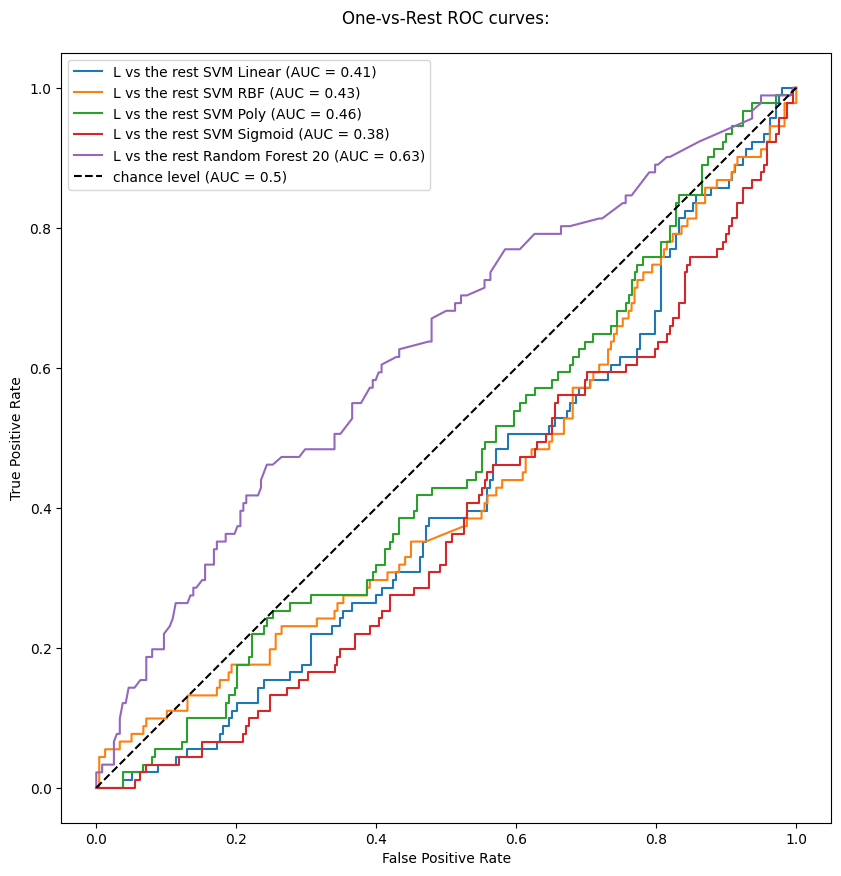

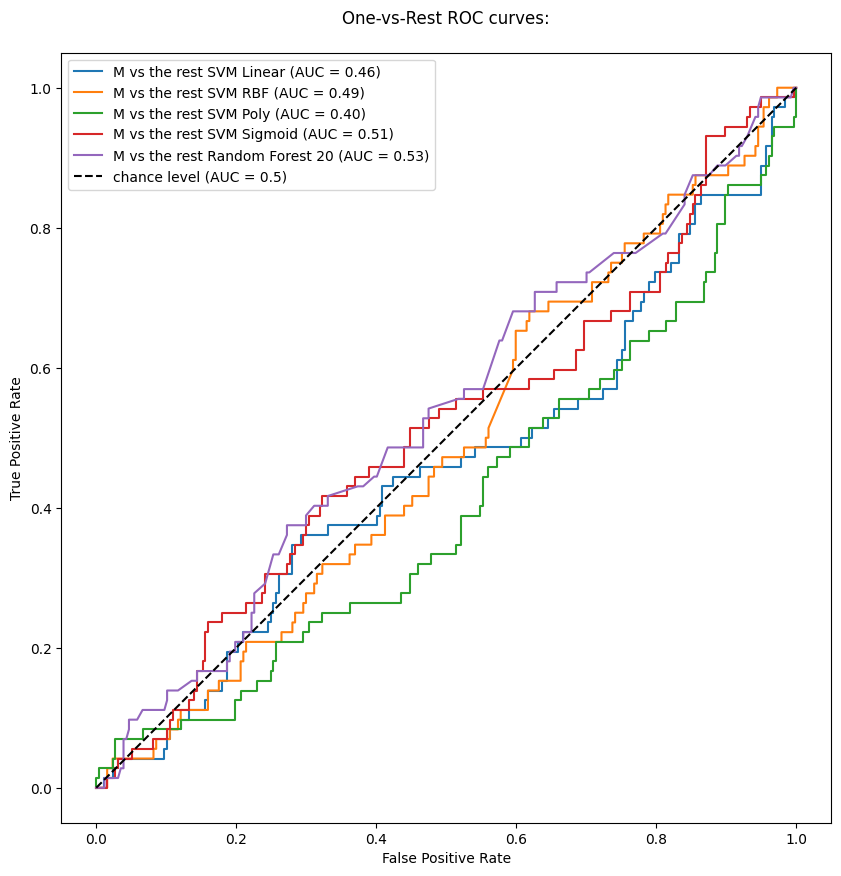

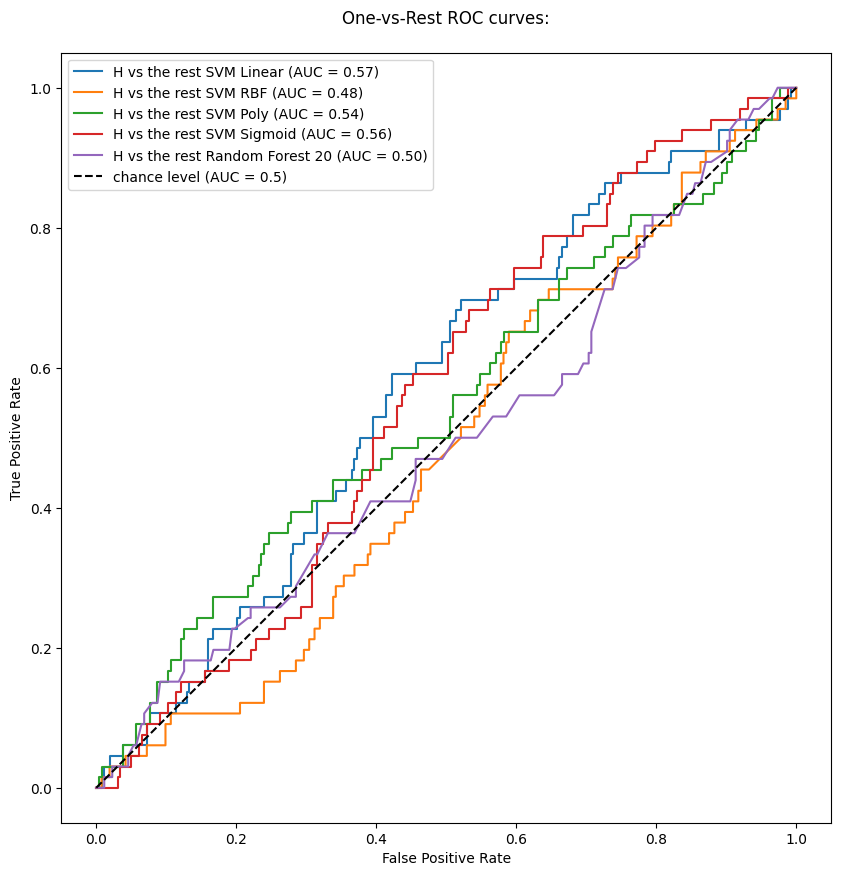

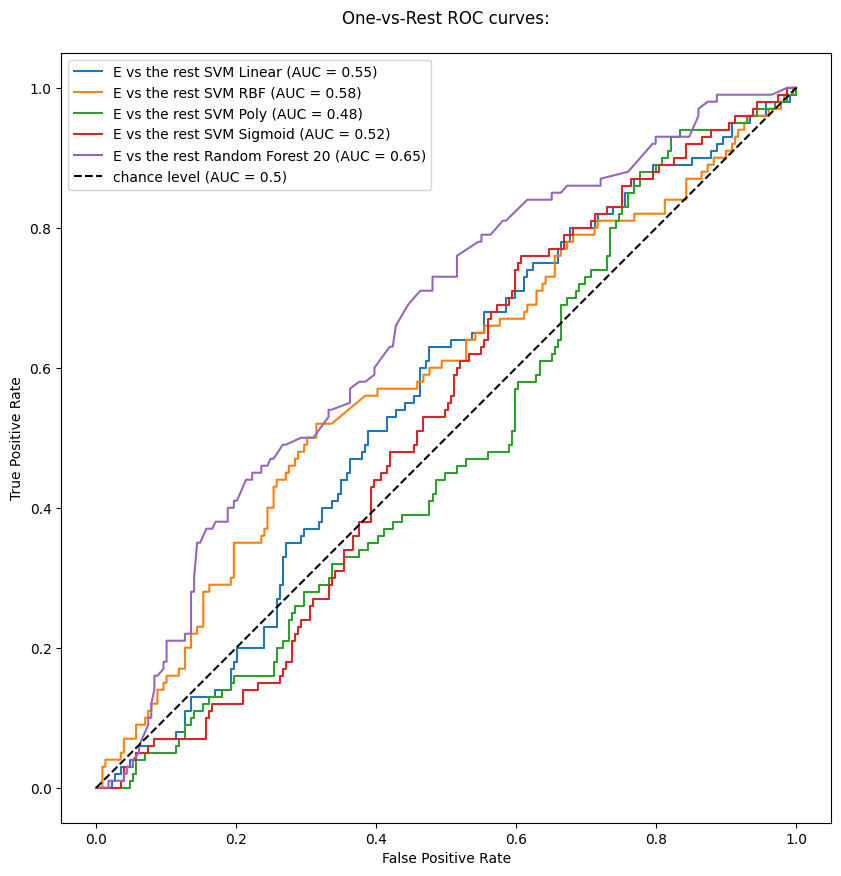

In [265]:
for label in labels:
    plotModelTogether(dfTestFeatures, label)

for label in labels:
    plotModelTogether(dfFeatures, label)

def printMacroROCAUC(y_test, y_score):
    print("Macro ROC AUC: ", roc_auc_score(
        y_test,
        y_score,
        multi_class="ovr",
        average="macro",
    ))



for i in range(2, 7):
    print("Model ", modelNames[i-1])
    printMacroROCAUC(y_onehot_test, eval('model0' + str(i)).decision_function(dfTestFeatures))

In [266]:
dfTestScaled.to_csv('test_all.csv', index=False)

import tensorflow as tf
from tensorflow import feature_column
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = dfTrainScaled.sample(n=dfTrainScaled.shape[0])
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 6
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  # model.add(tf.keras.layers.Flatten(input_shape=(1, 13)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=6, input_shape=(13,), activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])
  return model        


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
 
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # # To track the progression of training, we're going to take a snapshot
  # # of the model's root mean squared error at each epoch. 
  rmse = hist["mean_squared_error"]

  return epochs, rmse

print("Defined the build_model and train_model functions.")

## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature. 


excludeList = ['SIZE_HA_BIN', 'YEAR', 'DAY', 'DAYW', 'MAXTEMP', 'MEANHUMIDITY', 'MEANWINDSPEED', 'MAXWINDSPEED', 'RAIN']
dfFeatures = dfTrainScaled.drop(excludeList, axis=1)
# dfLabel = dfTrainScaled['SIZE_HA_BIN']
# dfLabel['SIZE_HA_BIN'] = feature_column.categorical_column_with_vocabulary_list('Type', ['L', 'M', 'H', 'E'])
dfLabel = dfFireWeather[dfFireWeather['YEAR'].isin(
    [2010, 2011, 2012, 2013, 2014, 2015, 2016])]['SIZE_HA'].copy(deep=True)


dfFeatures.dtypes

# The following variables are the hyperparameters.
learning_rate = 10
epochs = 30
batch_size = 1

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
epochs, rmse = train_model(my_model, dfFeatures.to_numpy(), dfLabel, epochs, batch_size)

# print("\nThe learned weight for your model is %.4f" % weight)
# print("The learned bias for your model is %.4f\n" % bias )

# plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

# plotter = tfdocs.plots.HistoryPlotter(metric = 'sparse_categorical_crossentropy', smoothing_std=10)
# plotter.plot(size_histories)
# plt.ylim([0.5, 0.7])


## Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this exercise, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

def predict(feature, label):
  """Predict house values based on a feature."""
  predicted_values = my_model.predict_on_batch(x=feature)
  print(predicted_values)
  show_metrics(label.astype(float), predicted_values)

dfTestScaled = pd.DataFrame()
for colNum in range(0, len(dfTest.columns)):
    dfTestScaled[dfTest.columns[colNum]] = (dfTest[dfTest.columns[colNum]] - dfMeans[colNum]) / dfStdevs[colNum]
    # dfTestScaled = (dfTest - dfMeans) / dfStdevs

# shift the wole test set to be positive
# dfTestScaled = dfTestScaled + 3

# add year column back
dfTestScaled['YEAR'] = dfTest['YEAR']
dfTestScaled['SIZE_HA_BIN'] = dfFireWeather[dfFireWeather['YEAR'].isin(
    [2017, 2018, 2019, 2020])]['SIZE_HA'].copy(deep=True)


print(dfTestScaled.drop(excludeList, axis=1).dtypes)
print(dfTestScaled['SIZE_HA_BIN'].dtypes)

predict(dfTestScaled.drop(excludeList, axis=1), dfTestScaled['SIZE_HA_BIN'])

# create nn model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# train model
model.fit(dfFeatures, dfLabel, epochs=100)



# predict on test data  
dfTestScaled['PREDICTED_SIZE_HA_BIN10'] = model.predict_classes(dfTestFeatures)

# show metrics for each model
print("Model 10")
show_metrics(dfTestScaled['SIZE_HA_BIN'], dfTestScaled['PREDICTED_SIZE_HA_BIN10'])